# <b>Assignment 3: RNNs for stock price prediction</b>


In [1]:
# install some requirement libraries
!pip install torch-summary
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 15.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=317865 sha256=d14ce84caca43538076f491c111a73a677d55cd29247cfd59fc3a0979e66fa33
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee


In [2]:
!pip install plotly

In [3]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import yfinance as yf
import tensorflow as tf
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go
import warnings
import optuna

from matplotlib.patches import Rectangle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError

In [4]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Helper function

In [49]:
def plot_mse_comparison(models_histories, model_names):
    fig, axs = plt.subplots(len(models_histories), 1, figsize=(12, len(models_histories) * 4))
    
    for i, (history, name) in enumerate(zip(models_histories, model_names)):
        axs[i].plot(history.history['mse'], label='Train MSE', color='blue', marker='o')
        axs[i].plot(history.history['val_mse'], label='Validation MSE', color='orange', marker='h')
        axs[i].set_title(f'MSE Comparison for {name}')
        axs[i].set_ylabel('MSE')
        axs[i].set_xlabel('Epoch')
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_grouped_predictions(predictions_list, indices, data_source, y_test, titles):
    num_plots = len(predictions_list)  # Number of models to plot
    fig, axs = plt.subplots(2, num_plots, figsize=(num_plots * 6, 16), sharey='row')
    # Adjust spacing between rows and columns
    plt.subplots_adjust(hspace=5.8, wspace=0.3)
    
    test_range = len(data_source) - len(y_test)
    
    for i, (predictions, idx, title) in enumerate(zip(predictions_list, indices, titles)):
        # Main plot (first row)
        ax_main = axs[0, i]
        ax_main.set_title(title, fontsize=24, pad=50)  # Add padding to the title
        ax_main.set_xlabel('Date', fontsize=14)
        if i == 0:  # Only the first column has a y-label
            ax_main.set_ylabel('Closing Price', fontsize=14)
        
        # Plot actual and predicted values
        ax_main.plot(data_source.iloc[:test_range, idx], label='Train Data', color='blue')
        ax_main.plot(data_source.iloc[test_range:, idx], label='Test Data', color='orange')
        ax_main.plot(data_source[test_range:].index, predictions[:, idx], label='Prediction', color='green')
        
        # Add a rectangle to highlight prediction area
        window_start = data_source[test_range:].index[0]
        window_end = data_source[test_range:].index[-1]
        width = window_end - window_start
        height = max(predictions[:, idx]) - min(predictions[:, idx]) + 30
        rectangle = Rectangle(
            (window_start, min(predictions[:, idx]) - 10),
            width,
            height,
            fill=False,
            edgecolor='red',
            linestyle='dashed'
        )
        ax_main.add_patch(rectangle)
        ax_main.legend(loc='lower right', fontsize=12)
        ax_main.grid(True)

        # Add some vertical spacing
        axs[1, i].set_position([axs[1, i].get_position().x0,
                                axs[1, i].get_position().y0 + 0.1,
                                axs[1, i].get_position().width,
                                axs[1, i].get_position().height])
        
        # Magnified plot (second row)
        ax_zoom = axs[1, i]
        ax_zoom.plot(data_source.iloc[test_range:, idx], color='orange', label='Test Data')
        ax_zoom.plot(data_source[test_range:].index, predictions[:, idx], color='green', label='Prediction')
        ax_zoom.set_xlim(window_start, window_end)
        ax_zoom.set_ylim(min(predictions[:, idx]) - 10, max(predictions[:, idx]) + 10)
        ax_zoom.set_title(f'Magnified View: {title}', fontsize=24, pad=50)  # Add padding to the magnified view title
        ax_zoom.set_xlabel('Date', fontsize=14)
        if i == 0:  # Only the first column has a y-label
            ax_zoom.set_ylabel('Closing Price', fontsize=14)
        ax_zoom.legend(loc='lower right', fontsize=12)
        ax_zoom.grid(True)
    plt.tight_layout()
    plt.show()

## <b>1: Exploratory Data Analysis (EDA)</b>

In [42]:
# Display Google's stock price data
ticker = yf.Ticker('GOOG')

start_date = '2012-01-03'

dataset = ticker.history(start=start_date, end=None)

dataset.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,16.222704,16.600606,16.208540,16.532528,147611217,0.0,0.0
2012-01-04 00:00:00-05:00,16.523088,16.652782,16.413519,16.603836,114989399,0.0,0.0
2012-01-05 00:00:00-05:00,16.451035,16.496751,16.304445,16.373516,131808205,0.0,0.0
2012-01-06 00:00:00-05:00,16.376995,16.398115,16.144440,16.150156,108119746,0.0,0.0
2012-01-09 00:00:00-05:00,16.062697,16.075122,15.434848,15.465409,233776981,0.0,0.0


In [7]:
# Define the candlestick chart trace using the stock data
candlestick_trace = go.Candlestick(
    x=dataset.index,
    open=dataset['Open'],
    high=dataset['High'],
    low=dataset['Low'],
    close=dataset['Close'],
    name='Candlestick'
)

# Define the layout of the chart
chartLayout = go.Layout(
    title='Google Stock Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Combine the candlestick trace and layout into a figure object
fig = go.Figure(data=[candlestick_trace], layout=chartLayout)

# Disable the range slider for the x-axis in the figure layout
fig.update_layout(xaxis_rangeslider_visible=False)

fig.show()

In [8]:
# Reorder the 'Close' column to the first position
dataset = dataset[['Close'] + [col for col in dataset.columns if col != 'Close']]
dataset.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03,16.532528,16.222704,16.600606,16.208540,147611217,0.0,0.0
2012-01-04,16.603836,16.523088,16.652782,16.413519,114989399,0.0,0.0
2012-01-05,16.373516,16.451035,16.496751,16.304445,131808205,0.0,0.0
2012-01-06,16.150156,16.376995,16.398115,16.144440,108119746,0.0,0.0
2012-01-09,15.465409,16.062697,16.075122,15.434848,233776981,0.0,0.0


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3253 entries, 2012-01-03 to 2024-12-05
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         3253 non-null   float64
 1   Open          3253 non-null   float64
 2   High          3253 non-null   float64
 3   Low           3253 non-null   float64
 4   Volume        3253 non-null   int64  
 5   Dividends     3253 non-null   float64
 6   Stock Splits  3253 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 203.3+ KB


In [10]:
dataset.isna().sum().to_frame(name='num_of_NaN')

,num_of_NaN
Close,0
Open,0
High,0
Low,0
Volume,0
Dividends,0
Stock Splits,0


In [11]:
dataset.duplicated().sum()

0

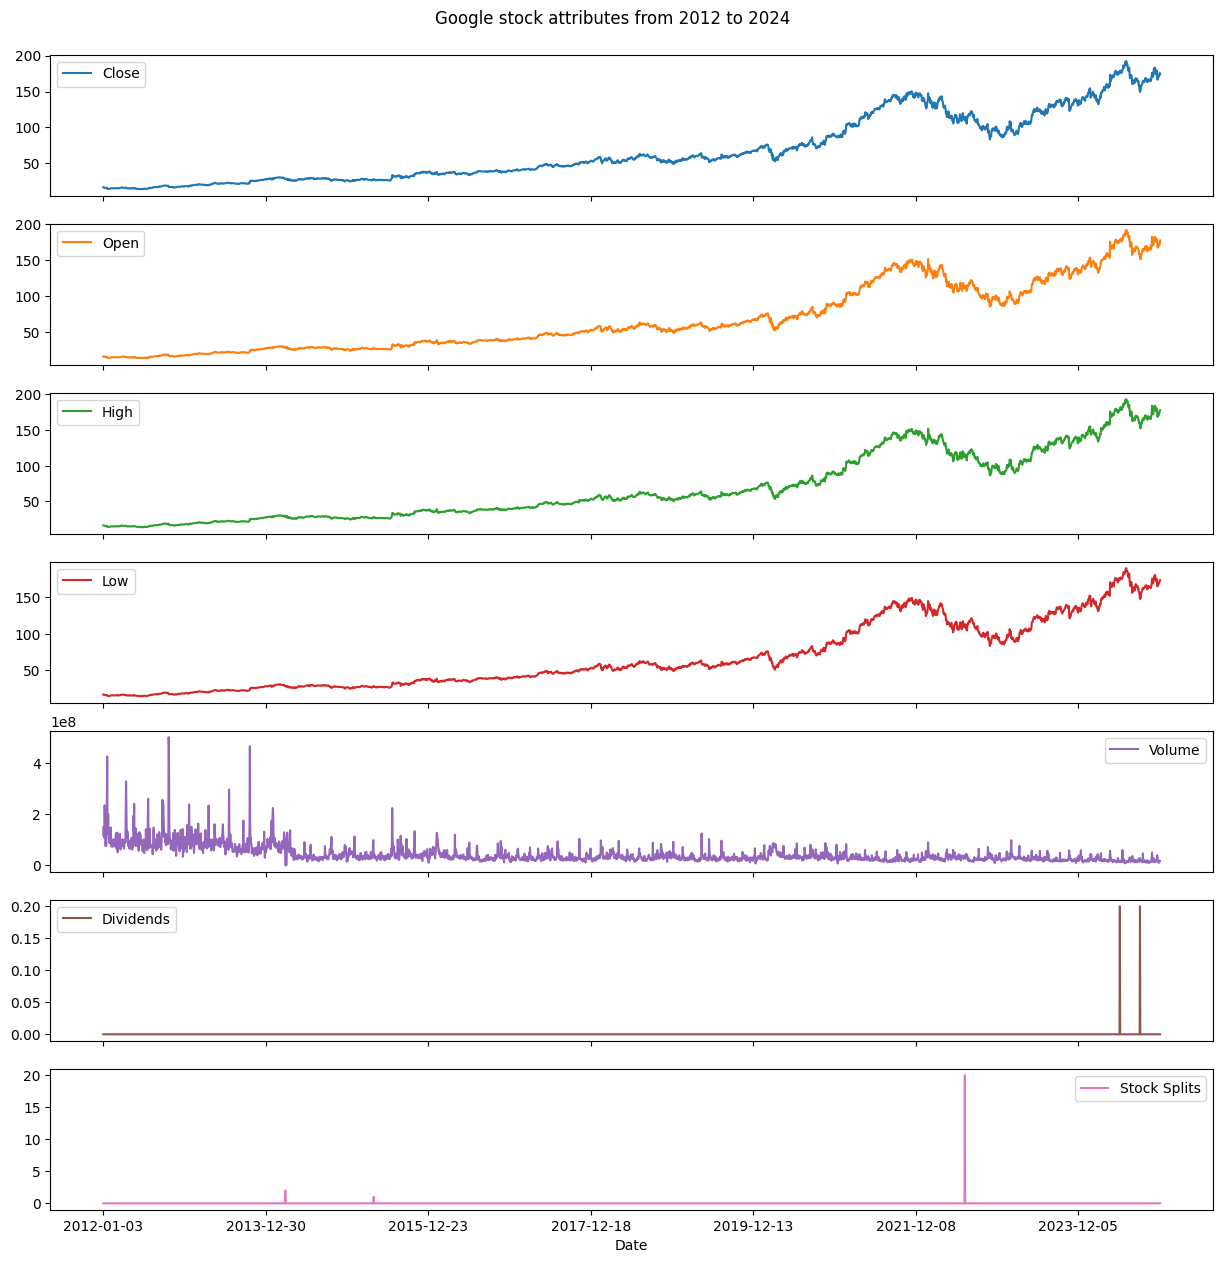

In [12]:
dataset.plot(subplots=True, figsize=(15, 15))
plt.suptitle('Google stock attributes from 2012 to 2024', y=0.91)
plt.show()

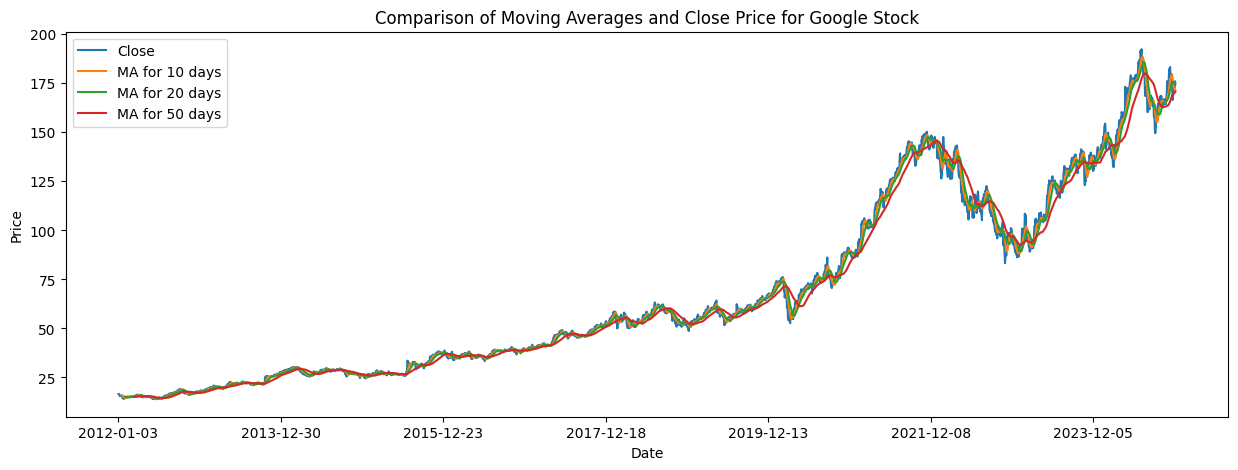

In [15]:
# Define moving average windows
ma_day = [10, 20, 50]

# Compute moving averages using a dictionary for flexibility
ma_columns = {f'MA for {ma} days': dataset['Close'].rolling(window=ma).mean() for ma in ma_day}

# Add the computed MAs to the dataset
dataset = dataset.assign(**ma_columns)

# Plot Close price and moving averages
columns_to_plot = ['Close'] + list(ma_columns.keys())
dataset[columns_to_plot].plot(figsize=(15, 5))

plt.title('Comparison of Moving Averages and Close Price for Google Stock')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

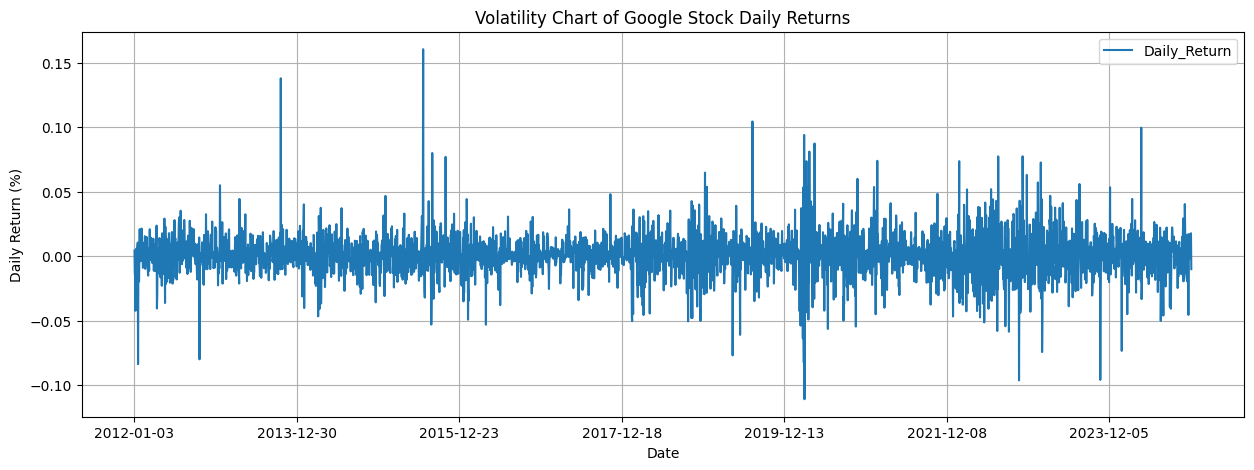

In [16]:
# Compute daily return percentage
dataset = dataset.assign(Daily_Return=lambda x: x['Close'].pct_change())

# Plot daily return
dataset['Daily_Return'].plot(figsize=(15, 5), legend=True)

# Add plot title and labels
plt.title('Volatility Chart of Google Stock Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.grid(True)
plt.show()

## <b>2. Data Pre-processing</b>

In [17]:
# Data Normalization
dataset_clone = dataset.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0, 15))

# Apply the scaler to all relevant columns at once
columns_to_scale = ['Open', 'High', 'Low', 'Close']
dataset_clone[columns_to_scale] = scaler.fit_transform(dataset_clone[columns_to_scale])

# Extract the scaled data as a NumPy array
data = dataset_clone[columns_to_scale].values
data.shape

(3253, 4)

In [18]:
# Preparing Data for Time Series
sequence_length = 11
sequences = []
for index in range(len(data) - sequence_length + 1): 
    sequences.append(data[index: index + sequence_length])
sequences = np.array(sequences)

In [19]:
# Define percentages for validation and test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

# Calculate the test size ratio
test_ratio = test_set_size_percentage / 100
valid_ratio = valid_set_size_percentage / (100 - test_set_size_percentage)  # Adjust for remaining data after test split

# First, split off the test set
train_valid_sequences, x_test, train_valid_targets, y_test = train_test_split(
    sequences[:, :-1, :], sequences[:, -1, :], test_size=test_ratio, random_state=42, shuffle=False
)

# Then, split the remaining data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    train_valid_sequences, train_valid_targets, test_size=valid_ratio, random_state=42, shuffle=False
)

## <b>3. Predicting models</b>

### 3.1 Vanilla RNN

In [20]:
vanilla_rnn = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(sequence_length-1, 4)),
    Dense(4)
])

vanilla_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,954 (11.54 KB)

 Trainable params: 2,954 (11.54 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
vanilla_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [22]:
vanilla_rnn_hist = vanilla_rnn.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 15.6319 - mse: 15.6319 - val_loss: 22.4428 - val_mse: 22.4428
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4943 - mse: 5.4943 - val_loss: 9.4100 - val_mse: 9.4100
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6191 - mse: 2.6191 - val_loss: 4.0046 - val_mse: 4.0046
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3936 - mse: 1.3936 - val_loss: 1.8279 - val_mse: 1.8279
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9582 - mse: 0.9582 - val_loss: 0.8168 - val_mse: 0.8168
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6154 - mse: 0.6154 - val_loss: 0.3941 - val_mse: 0.3941
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3784 - mse: 0.3784 - val_loss: 0.1734 - val_mse: 0.1734
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2504 - mse: 0.2504 - val_loss: 0.1334 - val_mse: 0.1334
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1354 - 

In [23]:
# Make predictions
predictions_vanilla_rnn = vanilla_rnn.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, predictions_vanilla_rnn)
print(f'MSE of Model Vanilla RNN: {mse:.3f}')

# Rescale predictions back to the original scale
predictions_vanilla_rnn = scaler.inverse_transform(predictions_vanilla_rnn)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MSE of Model Vanilla RNN: 1.914


### 3.2 Stacked LSTM

In [24]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length-1, 4)))
stacked_lstm.add(LSTM(units=50))
stacked_lstm.add(Dropout(0.2))
stacked_lstm.add(Dense(units=4))

stacked_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,404 (122.67 KB)

 Trainable params: 31,404 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
stacked_lstm.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [26]:
stacked_lstm_hist = stacked_lstm.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 13.6839 - mse: 13.6839 - val_loss: 14.9439 - val_mse: 14.9439
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0732 - mse: 3.0732 - val_loss: 2.4057 - val_mse: 2.4057
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2366 - mse: 1.2366 - val_loss: 0.5411 - val_mse: 0.5411
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6004 - mse: 0.6004 - val_loss: 0.2664 - val_mse: 0.2664
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3497 - mse: 0.3497 - val_loss: 0.4152 - val_mse: 0.4152
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2569 - mse: 0.2569 - val_loss: 0.2428 - val_mse: 0.2428
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2080 - mse: 0.2080 - val_loss: 0.1471 - val_mse: 0.1471
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2148 - mse: 0.2148 - val_loss: 0.1466 - val_mse: 0.1466
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0

In [27]:
# Make predictions
prediction_stacked_lstm = stacked_lstm.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, prediction_stacked_lstm)
print(f'MSE of Model Stacked LSTM: {mse:.3f}')

# Rescale predictions back to the original scale
prediction_stacked_lstm = scaler.inverse_transform(prediction_stacked_lstm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
MSE of Model Stacked LSTM: 0.986


### 3.3 Gated Recurrent Unit (GRU)

In [28]:
gru = Sequential([
    GRU(50, return_sequences=False, input_shape=(sequence_length-1, 4)),
    Dense(4)
])

gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,604 (33.61 KB)

 Trainable params: 8,604 (33.61 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile model
gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [30]:
# Train model
gru_hist = gru.fit(x_train, 
                   y_train, 
                   epochs=50, 
                   batch_size=64, 
                   validation_data=(x_valid, y_valid))

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 13.1370 - mse: 13.1370 - val_loss: 17.3431 - val_mse: 17.3431
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0248 - mse: 4.0248 - val_loss: 7.5882 - val_mse: 7.5882
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3292 - mse: 2.3292 - val_loss: 3.1709 - val_mse: 3.1709
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3101 - mse: 1.3101 - val_loss: 1.1605 - val_mse: 1.1605
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7623 - mse: 0.7623 - val_loss: 0.3955 - val_mse: 0.3955
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3771 - mse: 0.3771 - val_loss: 0.1529 - val_mse: 0.1529
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2278 - mse: 0.2278 - val_loss: 0.0876 - val_mse: 0.0876
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1157 - mse: 0.1157 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0735 - 

In [31]:
prediction_gru = gru.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, prediction_gru)
print(f'MSE of GRU: {mse:.3f}')

prediction_gru = scaler.inverse_transform(prediction_gru)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE of GRU: 1.781


In [32]:
# Save the entire model to a HDF5 file.
stacked_lstm.save('/kaggle/working/stacked_lstm_model.h5')

### 3.4 Hyperparameter tuning (Stacked LSTM)

In [33]:
# Load the model with custom_objects
final_model = load_model(
    '/kaggle/working/stacked_lstm_model.h5',
    custom_objects={'mse': MeanSquaredError()}
)

# Verify the model
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,406 (122.68 KB)

 Trainable params: 31,404 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [34]:
def objective(trial, model):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 30, 100)
    
    # Clone the model to avoid modifying the original
    tuning_model = tf.keras.models.clone_model(model)
    tuning_model.set_weights(model.get_weights())
    
    # Recompile the model with tuned learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    tuning_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    # Train the model with tuned hyperparameters
    hyper_history = tuning_model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_valid, y_valid),
        verbose=0
    )
    
    # Predict and calculate validation loss
    predictions = tuning_model.predict(x_valid)
    val_loss = mean_squared_error(y_valid, predictions)
    
    return val_loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, final_model), n_trials=50)

# Print best trial details
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value (validation loss):', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Retrain the model with best hyperparameters
best_model = tf.keras.models.clone_model(final_model)
best_model.set_weights(stacked_lstm.get_weights())
best_optimizer = tf.keras.optimizers.Adam(learning_rate=trial.params['learning_rate'])
best_model.compile(optimizer=best_optimizer, loss='mse', metrics=['mse'])

# Fit with best hyperparameters
best_model.fit(
    x_train,
    y_train,
    epochs=trial.params['epochs'],
    batch_size=trial.params['batch_size'],
    validation_data=(x_valid, y_valid)
)

# Predict and calculate MSE on test set
prediction_best_lstm = best_model.predict(x_test)
prediction_best_lstm = scaler.inverse_transform(prediction_best_lstm)

# Save the best model
best_model.save('best_stacked_lstm.h5')

[I 2024-12-06 05:34:29,247] A new study created in memory with name: no-name-b2a2133d-f517-4c1b-86d7-53a9912be9b5


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:34:58,301] Trial 0 finished with value: 0.08680833017203557 and parameters: {'learning_rate': 0.00795288780806195, 'batch_size': 64, 'epochs': 47}. Best is trial 0 with value: 0.08680833017203557.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:35:24,814] Trial 1 finished with value: 0.04736772273742122 and parameters: {'learning_rate': 0.0004605694407431465, 'batch_size': 64, 'epochs': 42}. Best is trial 1 with value: 0.04736772273742122.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-12-06 05:36:14,501] Trial 2 finished with value: 0.036306954123566715 and parameters: {'learning_rate': 0.008626896305990379, 'batch_size': 64, 'epochs': 85}. Best is trial 2 with value: 0.036306954123566715.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:36:52,861] Trial 3 finished with value: 0.0409820263144268 and parameters: {'learning_rate': 0.0003660617621402056, 'batch_size': 128, 'epochs': 79}. Best is trial 2 with value: 0.036306954123566715.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 05:37:38,282] Trial 4 finished with value: 0.06756942029895681 and parameters: {'learning_rate': 0.0022537244524238717, 'batch_size': 64, 'epochs': 78}. Best is trial 2 with value: 0.036306954123566715.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:38:35,795] Trial 5 finished with value: 0.030636601448532797 and parameters: {'learning_rate': 0.000226342532448164, 'batch_size': 32, 'epochs': 61}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:39:13,678] Trial 6 finished with value: 0.04270583393341229 and parameters: {'learning_rate': 0.000329625386778496, 'batch_size': 32, 'epochs': 39}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:40:07,453] Trial 7 finished with value: 0.3092957826713723 and parameters: {'learning_rate': 0.009021736506820551, 'batch_size': 32, 'epochs': 57}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:40:55,250] Trial 8 finished with value: 0.25022819614395797 and parameters: {'learning_rate': 0.0056136344179618545, 'batch_size': 32, 'epochs': 50}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:41:51,468] Trial 9 finished with value: 0.03280439553520237 and parameters: {'learning_rate': 0.0025112521138780353, 'batch_size': 64, 'epochs': 95}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:42:24,418] Trial 10 finished with value: 0.03532975996070395 and parameters: {'learning_rate': 0.00011364958765516766, 'batch_size': 128, 'epochs': 68}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:43:54,697] Trial 11 finished with value: 0.04403523052824719 and parameters: {'learning_rate': 0.0016165040103934777, 'batch_size': 32, 'epochs': 99}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:44:50,311] Trial 12 finished with value: 0.05558580582616505 and parameters: {'learning_rate': 0.00014109746631527258, 'batch_size': 64, 'epochs': 97}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 05:45:50,904] Trial 13 finished with value: 0.04032820998083684 and parameters: {'learning_rate': 0.0030597494872390404, 'batch_size': 32, 'epochs': 65}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:46:23,128] Trial 14 finished with value: 0.12536175453685028 and parameters: {'learning_rate': 0.0009496901257625452, 'batch_size': 128, 'epochs': 66}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:46:43,918] Trial 15 finished with value: 0.03327964702383158 and parameters: {'learning_rate': 0.0007468457712325993, 'batch_size': 64, 'epochs': 31}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:48:06,766] Trial 16 finished with value: 0.03971894964694046 and parameters: {'learning_rate': 0.00022763730652626123, 'batch_size': 32, 'epochs': 87}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 05:49:02,285] Trial 17 finished with value: 0.03299232796307679 and parameters: {'learning_rate': 0.0042550649080800385, 'batch_size': 32, 'epochs': 57}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:49:46,893] Trial 18 finished with value: 0.03595616978565745 and parameters: {'learning_rate': 0.0016012524915189213, 'batch_size': 64, 'epochs': 74}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-12-06 05:50:28,597] Trial 19 finished with value: 0.040937728431059195 and parameters: {'learning_rate': 0.0006362424351043776, 'batch_size': 128, 'epochs': 87}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-12-06 05:51:03,493] Trial 20 finished with value: 0.033283510647039355 and parameters: {'learning_rate': 0.00021817541340635006, 'batch_size': 64, 'epochs': 57}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2024-12-06 05:51:59,081] Trial 21 finished with value: 0.06759276181450749 and parameters: {'learning_rate': 0.0038193136019873974, 'batch_size': 32, 'epochs': 58}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 05:52:48,734] Trial 22 finished with value: 0.04301485753329673 and parameters: {'learning_rate': 0.004108415338129344, 'batch_size': 32, 'epochs': 52}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:53:47,032] Trial 23 finished with value: 0.06625406342978624 and parameters: {'learning_rate': 0.0015740979864377123, 'batch_size': 32, 'epochs': 62}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-06 05:54:58,271] Trial 24 finished with value: 0.04615625526319616 and parameters: {'learning_rate': 0.002517113415574609, 'batch_size': 32, 'epochs': 75}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:56:04,684] Trial 25 finished with value: 0.0733712493681126 and parameters: {'learning_rate': 0.0051345554916607155, 'batch_size': 32, 'epochs': 70}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:56:47,392] Trial 26 finished with value: 0.039804732920689485 and parameters: {'learning_rate': 0.0011351079703215263, 'batch_size': 32, 'epochs': 43}. Best is trial 5 with value: 0.030636601448532797.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 05:58:14,291] Trial 27 finished with value: 0.029142804036648075 and parameters: {'learning_rate': 0.0021442253754419198, 'batch_size': 32, 'epochs': 93}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 05:58:57,246] Trial 28 finished with value: 0.04696355695226886 and parameters: {'learning_rate': 0.00212560585854716, 'batch_size': 128, 'epochs': 92}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-06 05:59:52,293] Trial 29 finished with value: 0.057950900831170854 and parameters: {'learning_rate': 0.00606882074640901, 'batch_size': 64, 'epochs': 95}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 06:00:43,549] Trial 30 finished with value: 0.04810905198491556 and parameters: {'learning_rate': 0.0012128119211655304, 'batch_size': 64, 'epochs': 84}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2024-12-06 06:02:10,819] Trial 31 finished with value: 0.08134234866060464 and parameters: {'learning_rate': 0.003428351321740917, 'batch_size': 32, 'epochs': 93}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:03:08,304] Trial 32 finished with value: 0.0490018085112225 and parameters: {'learning_rate': 0.0026686140388516443, 'batch_size': 32, 'epochs': 61}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 06:04:02,413] Trial 33 finished with value: 0.34101779668895166 and parameters: {'learning_rate': 0.006725748855637438, 'batch_size': 32, 'epochs': 53}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:05:37,657] Trial 34 finished with value: 0.04121380769765195 and parameters: {'learning_rate': 0.0018972245765319874, 'batch_size': 32, 'epochs': 100}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-06 06:06:26,710] Trial 35 finished with value: 0.06026497193540178 and parameters: {'learning_rate': 0.0006623335288445993, 'batch_size': 64, 'epochs': 82}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-06 06:07:51,173] Trial 36 finished with value: 0.04045108028057309 and parameters: {'learning_rate': 0.004528024205867827, 'batch_size': 32, 'epochs': 89}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:08:19,815] Trial 37 finished with value: 0.03655609195042299 and parameters: {'learning_rate': 0.0003846070593278064, 'batch_size': 64, 'epochs': 45}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:09:27,481] Trial 38 finished with value: 0.06825777137807919 and parameters: {'learning_rate': 0.007875469469972318, 'batch_size': 32, 'epochs': 71}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-06 06:10:07,175] Trial 39 finished with value: 0.041083730486044245 and parameters: {'learning_rate': 0.0030822785595899255, 'batch_size': 128, 'epochs': 80}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:10:43,785] Trial 40 finished with value: 0.03047764611429625 and parameters: {'learning_rate': 0.0008943566383688652, 'batch_size': 32, 'epochs': 36}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 06:11:22,043] Trial 41 finished with value: 0.07514803577228706 and parameters: {'learning_rate': 0.000500671586248532, 'batch_size': 32, 'epochs': 38}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-06 06:11:57,719] Trial 42 finished with value: 0.03893776616185195 and parameters: {'learning_rate': 0.0002235697452652665, 'batch_size': 32, 'epochs': 35}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:12:44,924] Trial 43 finished with value: 0.03277427578633789 and parameters: {'learning_rate': 0.0009226226591040902, 'batch_size': 32, 'epochs': 48}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2024-12-06 06:13:36,145] Trial 44 finished with value: 0.05151130447501645 and parameters: {'learning_rate': 0.0014053843098677768, 'batch_size': 32, 'epochs': 49}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 06:14:08,150] Trial 45 finished with value: 0.17814839846699526 and parameters: {'learning_rate': 0.0009607278561428322, 'batch_size': 32, 'epochs': 30}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:14:33,774] Trial 46 finished with value: 0.12707829986093933 and parameters: {'learning_rate': 0.0008125322848472903, 'batch_size': 64, 'epochs': 39}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:15:17,002] Trial 47 finished with value: 0.03272282400287532 and parameters: {'learning_rate': 0.0003032638331635266, 'batch_size': 32, 'epochs': 43}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:16:04,406] Trial 48 finished with value: 0.05802489349730063 and parameters: {'learning_rate': 0.0001470293857820669, 'batch_size': 32, 'epochs': 47}. Best is trial 27 with value: 0.029142804036648075.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 06:16:40,600] Trial 49 finished with value: 0.07510759837560496 and parameters: {'learning_rate': 0.00032798294305790184, 'batch_size': 32, 'epochs': 36}. Best is trial 27 with value: 0.029142804036648075.


Number of finished trials: 50
Best trial:
  Value (validation loss): 0.029142804036648075
  Params: 
    learning_rate: 0.0021442253754419198
    batch_size: 32
    epochs: 93
Epoch 1/93
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.2430 - mse: 0.2430 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 2/93
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1362 - mse: 0.1362 - val_loss: 0.0612 - val_mse: 0.0612
Epoch 3/93
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1115 - mse: 0.1115 - val_loss: 0.0934 - val_mse: 0.0934
Epoch 4/93
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1278 - mse: 0.1278 - val_loss: 0.1314 - val_mse: 0.1314
Epoch 5/93
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1425 - mse: 0.1425 - val_loss: 0.6837 - val_mse: 0.6837
Epoch 6/93
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1886 - mse: 0.1886 - val_loss: 0.3251 - val_mse: 0.3251
Epoch 7/93
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1381 - mse: 0.1381 - val_loss: 0.0401 - val_mse: 0.0401
Epoch

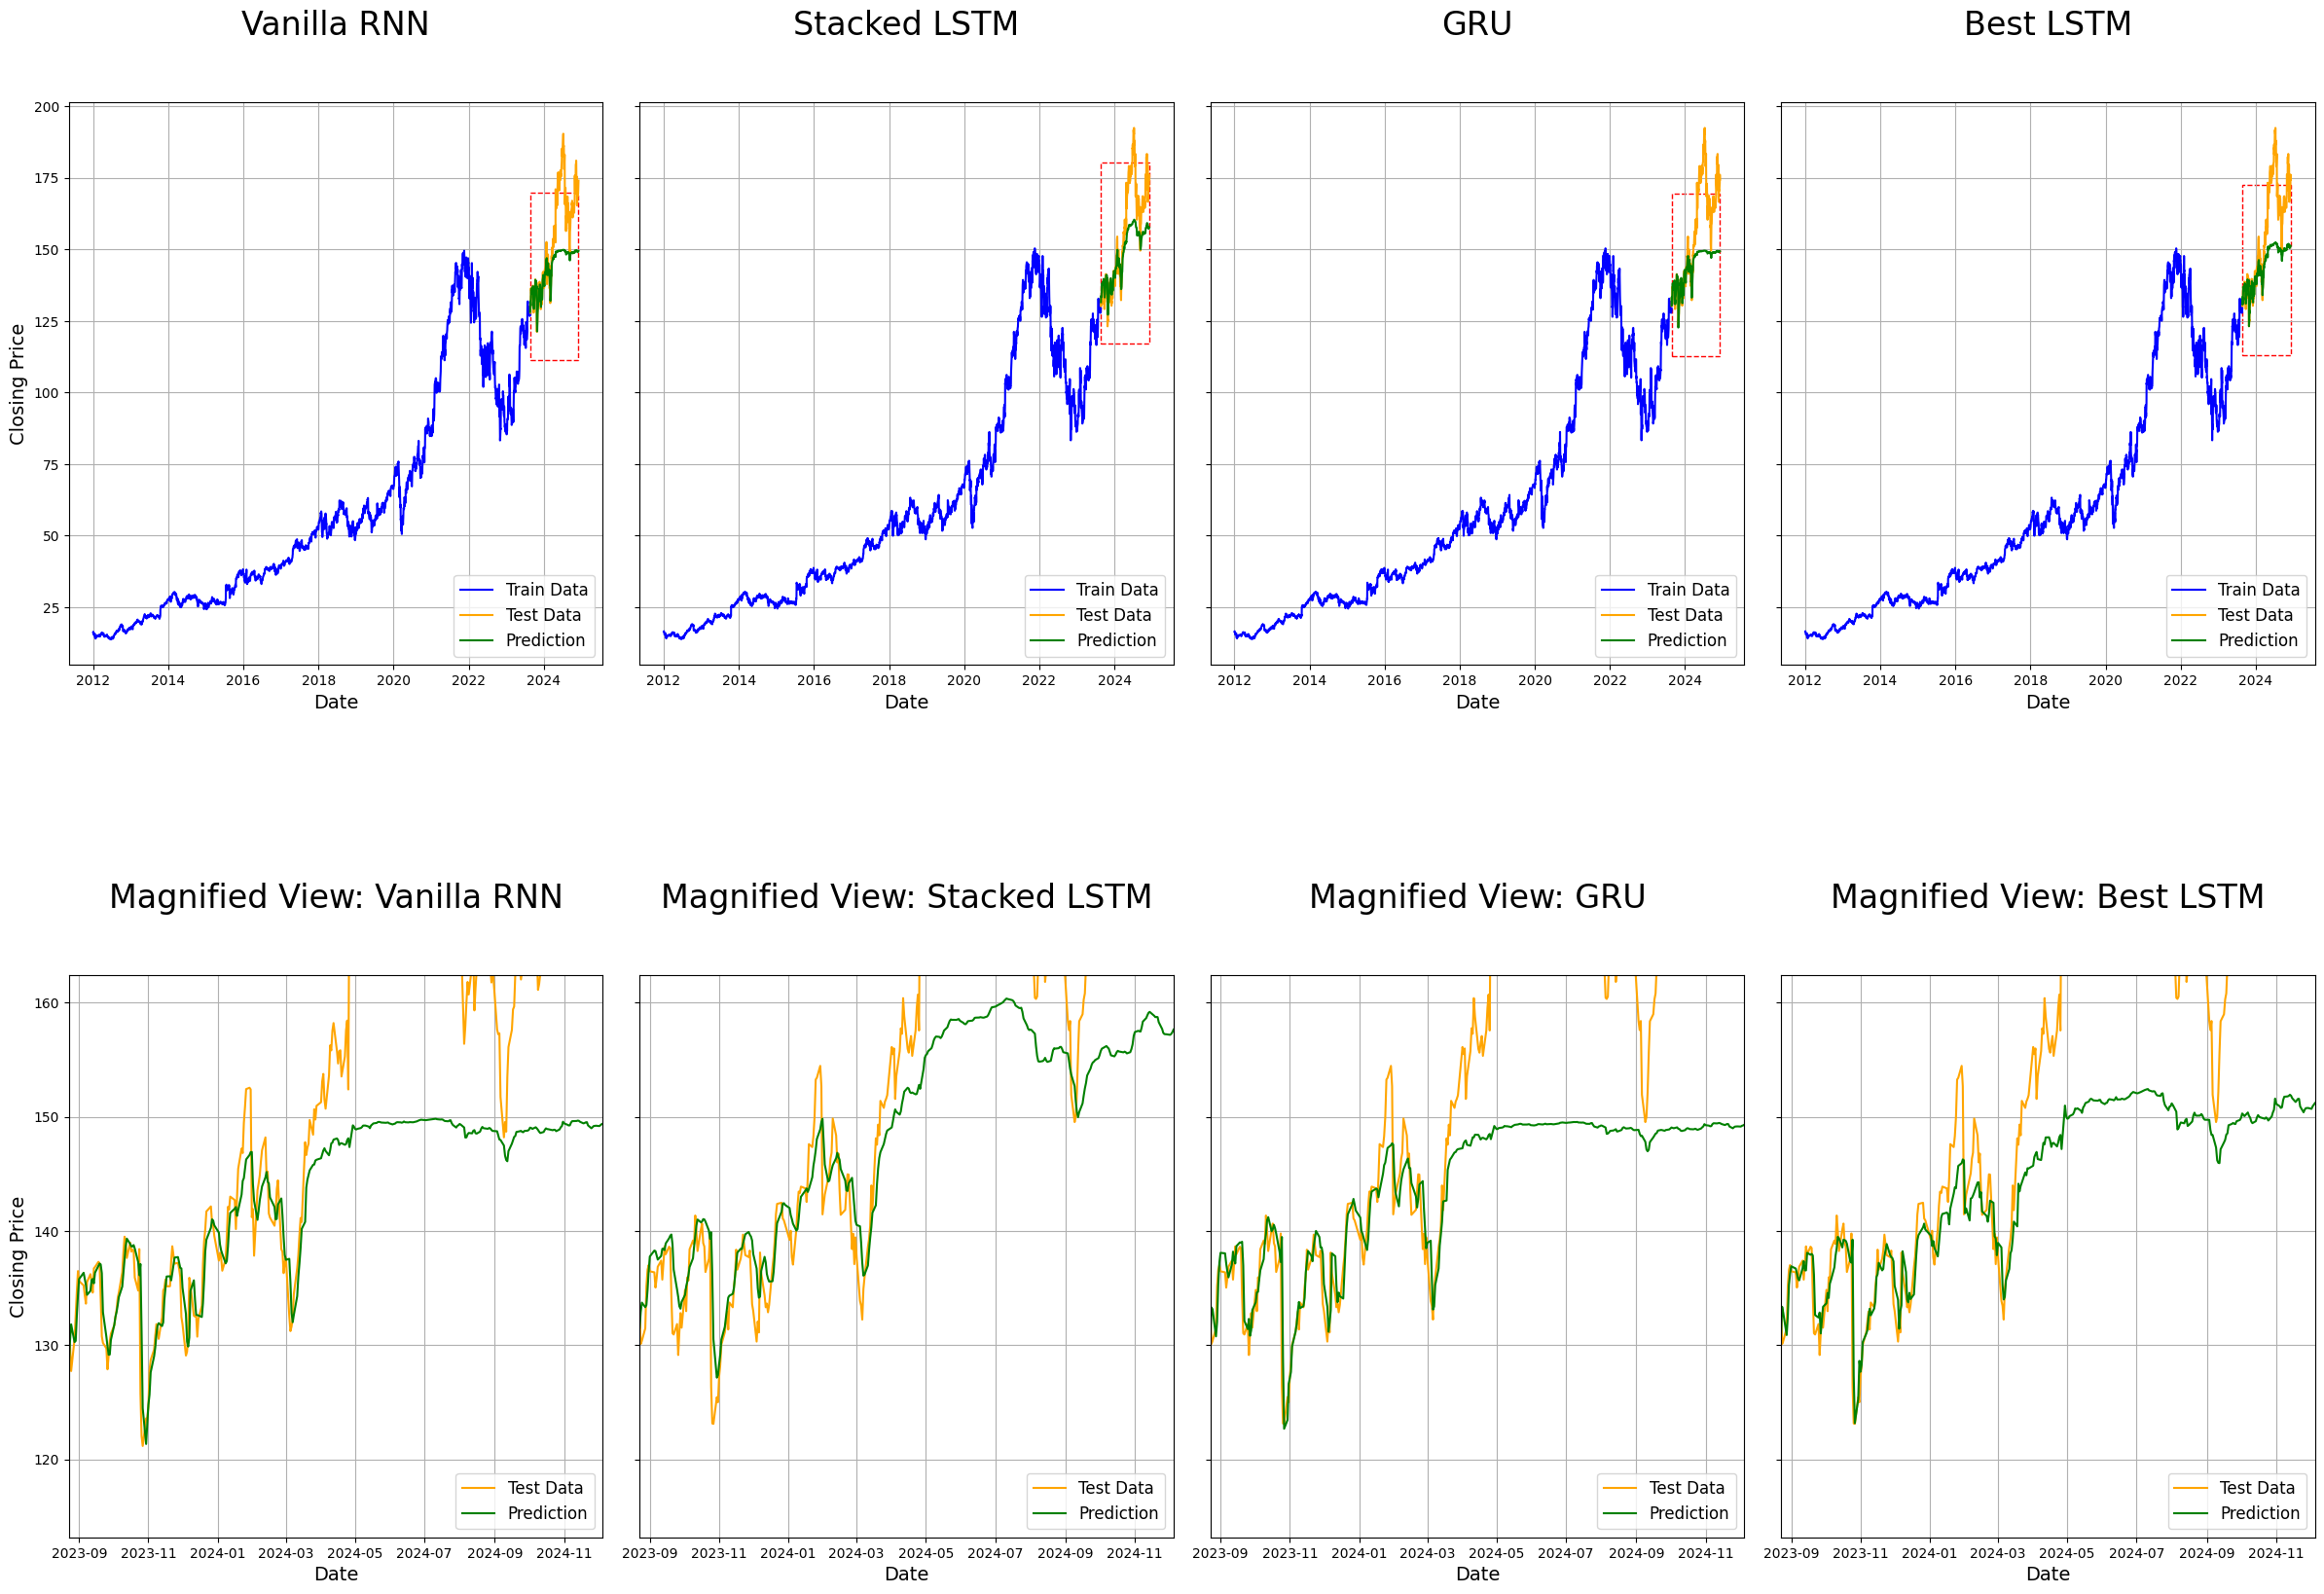

In [50]:
plot_grouped_predictions(
    predictions_list=[predictions_vanilla_rnn, prediction_stacked_lstm, prediction_gru, prediction_best_lstm],
    indices=[2, 3, 3, 3],
    data_source=dataset,
    y_test=y_test,
    titles=['Vanilla RNN', 'Stacked LSTM', 'GRU', 'Best LSTM']
)

### 3.5 Plotting

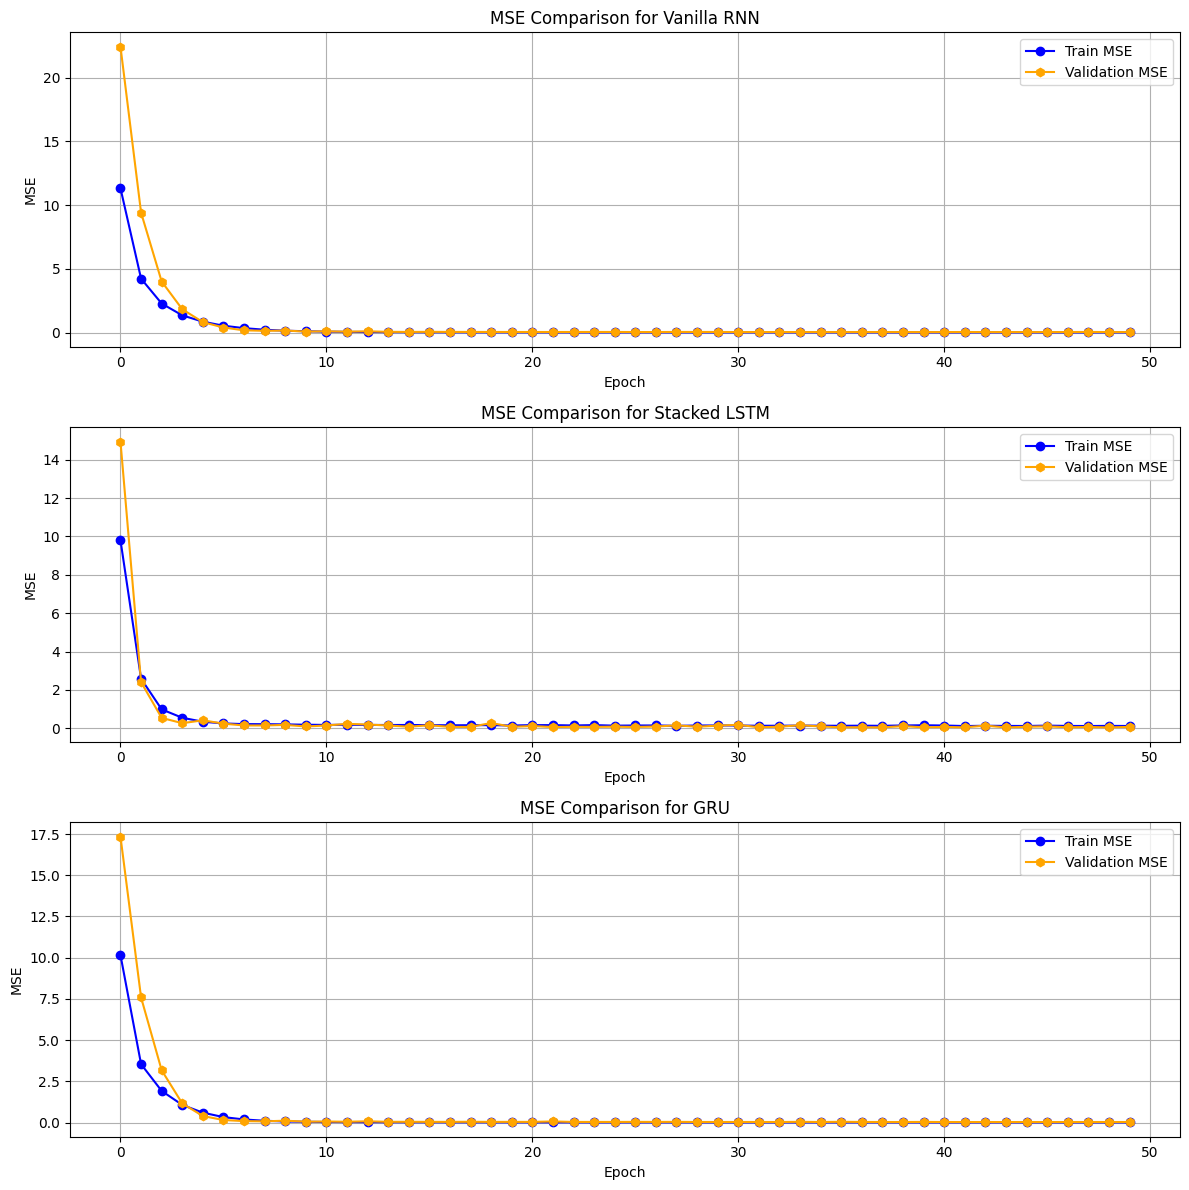

In [44]:
plot_mse_comparison(
    models_histories=[vanilla_rnn_hist, stacked_lstm_hist, gru_hist],
    model_names=['Vanilla RNN', 'Stacked LSTM', 'GRU']
)

## <b>4. Predicting the next 10 days</b>

In [45]:
prediction_best_model = best_model.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, prediction_best_model)
print(f'MSE of Hyperparameter-tuning Stacked LSTM: {mse:.3f}')

prediction_best_model = scaler.inverse_transform(prediction_best_model)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE of Hyperparameter-tuning Stacked LSTM: 1.763


In [46]:
# Predict the next 10 days of stock prices

# Extract the last sequence of historical data for prediction
recent_sequence = sequences[-1:, 1:, :]

# Define the number of days to predict
NUM_PREDICTIONS = 10

# Predict stock prices iteratively for the next NUM_PREDICTIONS days
for day in range(NUM_PREDICTIONS):
    # Predict the next time step
    next_prediction = best_model.predict(recent_sequence, verbose=0)
    # Append the prediction to the recent sequence
    recent_sequence = np.concatenate((recent_sequence, next_prediction[np.newaxis, :, :]), axis=1)
    # Remove the oldest time step to maintain sequence length
    recent_sequence = recent_sequence[:, 1:, :]

# Rescale the predictions back to their original values
predicted_prices = scaler.inverse_transform(recent_sequence.reshape(NUM_PREDICTIONS, 4))

# Create a DataFrame to store the predicted stock prices
predicted_df = pd.DataFrame(
    data=predicted_prices, 
    columns=['Open', 'High', 'Low', 'Close']
)

predicted_df

,Open,High,Low,Close
0,151.051506,152.829190,149.486654,151.315645
1,146.198805,147.936946,144.695209,146.481792
2,144.111131,145.827111,142.633313,144.399287
3,143.090608,144.795158,141.625218,143.380450
4,142.369777,144.066649,140.913027,142.660578
5,141.703273,143.393504,140.254455,141.995072
6,141.059271,142.743215,139.618074,141.351936
7,140.438559,142.116522,139.004623,140.731999
8,139.854823,141.527151,138.427640,140.148835
9,139.328800,140.996082,137.907676,139.623238
